In [111]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
import pandas as pd

In [112]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [113]:
distribution = stepmodel.read_zip(training_folder + r'model/transport/distribution.zip')
sm = stepmodel.read_zip(training_folder + r'model/preparation/walk_model.zip')

read_hdf: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 51.25it/s]


Model epsg not defined: setting epsg to default one: 4326
Model coordinates_unit not defined: setting coordinates_unit to default one: degree


read_hdf: 100%|████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 17.73it/s]


In [114]:
sm.volumes = distribution.volumes

# rail submodel

In [115]:
rail = sm.copy()
rail.links = rail.links.loc[rail.links['route_type'].isin(['tram', 'subway', 'rail'])] 

# strategy finder

In [116]:
rail.links['trip_id'] = rail.links['trip_id'].apply(lambda i: i.replace(':', '_').replace(' ', '_'))
rail.links= rail.links.loc[rail.links['a'] != rail.links['b']]

In [117]:
rail.nodes.index.name='index'
rail.step_strategy_finder()

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:38<00:00,  2.85it/s]


# assignment

In [50]:
rail.nodes.index.name='index'
rail.step_strategy_assignment('volume_pt_captive')

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:01<00:00, 76.71it/s]


ValueError: cannot reindex from a duplicate axis

In [103]:
import os
from graphviz import Source
os.environ["PATH"] += os.pathsep + r'C:\Users\qchasserieau\dev\graphviz-2.38\release\bin/'
from IPython.core import display
import numpy as np
import networkx as nx

rail.links['trip_id'] = rail.links['trip_id'].apply(lambda i: i.replace(':', '_').replace(' ', '_'))

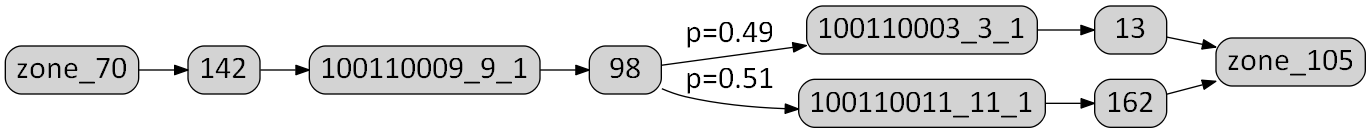

In [110]:
header = """
ratio = fill; 
node [style="filled,rounded" ,shape="record", fontname = "calibri", fontsize=24,];
edge[ fontname = "calibri", fontsize=24];
ranksep = "0.5";
rankdir="LR";
"""
origin, destination='zone_70',  'zone_105'
a = rail.get_aggregated_edges(origin, destination)
a['l'] = 'p=' + np.round(a['p'], 2).astype(str) #+ '\nh:' + a['h'].astype(str)
a.loc[a['p'] == 1, 'l'] = ''

odg = nx.DiGraph()
for e in a.to_dict(orient='records'):
    odg.add_edge(e['i'], e['j'], label=e['l'])
name='test'
dot_string = nx.nx_pydot.to_pydot(odg).to_string().replace('{', '{' + header)
src = Source(dot_string,format='png')
display.Image(filename=src.render(name))

In [109]:
sm.disaggregated_nodes

,geometry,stop_id
node_StopPoint:59:7931936,POINT (260329.2008208613 6255628.271463804),StopPoint:59:7931936
node_StopPoint:59:3754292,POINT (262033.6135443971 6245085.977050477),StopPoint:59:3754292
node_StopPoint:59:3747933,POINT (265247.2959241081 6250062.877883317),StopPoint:59:3747933
node_StopPoint:59:7964971,POINT (261349.3326344909 6249475.835086906),StopPoint:59:7964971
node_StopPoint:59:7921110,POINT (260921.5318313723 6246162.090239842),StopPoint:59:7921110
...,...,...
node_StopPoint:59:3741070,POINT (262453.6219831601 6257709.48533371),StopPoint:59:3741070
node_StopPoint:59775,POINT (254617.1751092769 6246424.713717619),StopPoint:59775
node_StopPoint:59:4723803,POINT (266378.190631077 6245650.733430466),StopPoint:59:4723803
node_StopPoint:59:7932173,POINT (264325.9044988123 6254250.33296087),StopPoint:59:7932173


In [87]:
self = rail
edges = self.optimal_strategy_edges[['i', 'j', 'f', 'c']].copy()
edges = edges.loc[self.optimal_strategy_sets.loc[destination]]
edges['ix'] = edges.index

# removing the edges that are non relevant (p<1e-6)
f_total = edges.groupby('i')[['f']].sum()
edges = pd.merge(edges, f_total, left_on='i', right_index=True, suffixes=['', '_total'])
edges['p'] = np.round(edges['f'] / edges['f_total'], 6)
edges = edges.loc[edges['p'] > 0]

In [89]:
#restriction to the origin
g = nx.DiGraph()
for e in edges.to_dict(orient='records'):
    g.add_edge(e['i'], e['j'])

paths = list(nx.all_simple_paths(g, source=origin, target=destination))
nodes = set.union(*[set(p) for p in paths])
ode = edges.loc[edges['i'].isin(nodes) & edges['j'].isin(nodes)]

In [99]:
rail.links.groupby(['a', 'b', 'trip_id']).first()

agency_id  arrival_time  bikes_allowed  block_id  \
a  b   trip_id                                                           
0  101 100110010_10_2       439       27780.0              0       NaN   
   115 100110010_10_1       439       28680.0              0       NaN   
1  178 100110012_12_0       439       28380.0              0       NaN   
   85  100110012_12_1       439       27540.0              0       NaN   
10 115 100110010_10_2       439       27480.0              0       NaN   
...                         ...           ...            ...       ...   
98 51  100110008_8_1        439       33420.0              0       NaN   
       100110009_9_1        439       28200.0              0       NaN   
   80  100110011_11_1       439       28380.0              0       NaN   
99 248 100110012_12_1       439       27060.0              0       NaN   
   69  100110012_12_0       439       28920.0              0       NaN   

                       departure_time  direction_id  \
a  b   trip_id                                        
0  101 100110010_10_2         27720.0             1   
   115 100110010_10_1         28620.0             0   
1  178 100110012_12_0         28320.0             0   
   85  100110012_12_1         27480.0             1   
10 115 100110010_10_2         27360.0             1   
...                               ...           ...   
98 51  100110008_8_1          33360.0             0   
       100110009_9_1          28140.0             0   
   80  100110011_11_1         28320.0             1   
99 248 100110012_12_1         27000.0             1   
   69  100110012_12_0         28800.0             0   

                                                                geometry  \
a  b   trip_id                                                             
0  101 100110010_10_2  LINESTRING (261031.2037937019 6249593.69715868...   
   115 100110010_10_1  LINESTRING (261485.6656148654 6249392.14673722...   
1  178 100110012_12_0  LINESTRING (260227.6774452579 6254259.89650316...   
   85  100110012_12_1  LINESTRING (260227.6774452579 6254259.89650316...   
10 115 100110010_10_2  LINESTRING (263207.310595576 6248372.913693948...   
...                                                                  ...   
98 51  100110008_8_1   LINESTRING (263067.4821831906 6252403.82380612...   
       100110009_9_1   LINESTRING (263095.3899795325 6252377.28870417...   
   80  100110011_11_1  LINESTRING (263060.5692428123 6252369.35188180...   
99 248 100110012_12_1  LINESTRING (262704.224420834 6256261.995327922...   
   69  100110012_12_0  LINESTRING (262704.224420834 6256261.995327922...   

                       headway  index  link_sequence  ... service_id shape_id  \
a  b   trip_id                                        ...                       
0  101 100110010_10_2    180.0   4798              5  ...       8893      NaN   
   115 100110010_10_1    180.0   4791             15  ...       8893      NaN   
1  178 100110012_12_0    129.0   4851             19  ...       8893      NaN   
   85  100110012_12_1    129.0   4865              8  ...       8893      NaN   
10 115 100110010_10_2    180.0   4794              1  ...       8893      NaN   
...                        ...    ...            ...  ...        ...      ...   
98 51  100110008_8_1     138.0   4659             17  ...       8893      NaN   
       100110009_9_1     112.0   4750             22  ...       8893      NaN   
   80  100110011_11_1    106.0   4826              5  ...       8893      NaN   
99 248 100110012_12_1    129.0   4859              2  ...       8893      NaN   
   69  100110012_12_0    129.0   4857             25  ...       8893      NaN   

                        time  trip_desc                 trip_headsign  \
a  b   trip_id                                                          
0  101 100110010_10_2   60.0        NaN  Boulogne Pont de Saint-Cloud   
   115 100110010_10_1   60.0        NaN             Gare d'Austerlitz   
1  178 1

,a,agency_id,arrival_time,b,bikes_allowed,block_id,departure_time,direction_id,geometry,headway,...,shape_id,time,trip_desc,trip_headsign,trip_id,trip_short_name,wheelchair_accessible,disaggregated_a,disaggregated_b,length
link_4186,98,439,28620.0,211,0,NaN,28500.0,1,"LINESTRING (263156.8828662466 6252379.6071377,...",109.0,...,NaN,120.0,NaN,Gallieni (Parc de Bagnolet),100110003_3_1,NaN,0,node_StopPoint:59587,node_StopPoint:59434,NaN
link_4197,98,439,27720.0,205,0,NaN,27660.0,0,LINESTRING (262927.3643401291 6252294.89165037...,106.0,...,NaN,60.0,NaN,Pont de Levallois-Bécon,100110003_3_2,NaN,0,node_StopPoint:59438,node_StopPoint:59588,NaN
link_4269,98,439,28080.0,51,0,NaN,27960.0,0,LINESTRING (263122.7523103695 6252449.95582031...,109.0,...,NaN,120.0,NaN,Place d'Italie,100110005_5_0,NaN,0,node_StopPoint:59634,node_StopPoint:59338,NaN
link_4287,98,439,28140.0,17,0,NaN,28020.0,1,LINESTRING (263122.7523103695 6252449.95582031...,109.0,...,NaN,120.0,NaN,Bobigny-Pablo-Picasso,100110005_5_1,NaN,0,node_StopPoint:59634,node_StopPoint:59340,NaN
link_4488,98,439,33420.0,51,0,NaN,33360.0,0,LINESTRING (263067.4821831906 6252403.82380612...,138.0,...,NaN,60.0,NaN,Pointe du Lac,100110008_8_1,NaN,0,node_StopPoint:59557,node_StopPoint:59472,NaN
link_4512,98,439,33120.0,127,0,NaN,33000.0,1,LINESTRING (263067.4821831906 6252403.82380612...,133.0,...,NaN,120.0,NaN,Balard,100110008_8_2,NaN,0,node_StopPoint:59557,node_StopPoint:59273,NaN
link_4537,98,439,28080.0,127,0,NaN,27960.0,1,LINESTRING (263095.3899795325 6252377.28870417...,109.0,...,NaN,120.0,NaN,Pont de Sèvres,100110009_9_0,NaN,0,node_StopPoint:59618,node_StopPoint:59274,NaN
link_4579,98,439,28200.0,51,0,NaN,28140.0,0,LINESTRING (263095.3899795325 6252377.28870417...,112.0,...,NaN,60.0,NaN,Mairie de Montreuil,100110009_9_1,NaN,0,node_StopPoint:59618,node_StopPoint:59341,NaN
link_4629,98,439,29040.0,205,0,NaN,28920.0,0,LINESTRING (263060.5692428123 6252369.35188180...,109.0,...,NaN,120.0,NaN,Châtelet,100110011_11_0,NaN,0,node_StopPoint:59643,node_StopPoint:59642,NaN
link_4637,98,439,28380.0,80,0,NaN,28320.0,1,LINESTRING (263060.5692428123 6252369.35188180...,106.0,...,NaN,60.0,NaN,Mairie des Lilas,100110011_11_1,NaN,0,node_StopPoint:59643,node_StopPoint:59640,NaN


In [90]:
ode

,i,j,f,c,ix,f_total,p
ix,,,,,,,
link_4187,"(211, 100110003_3_1)","(13, 100110003_3_1)",1.000000e+09,60.000000,link_4187,1.000000e+09,1.000000
297,zone_75,40,1.000000e+09,463.749904,297,1.000000e+09,1.000000
655,162,zone_105,1.000000e+09,391.146184,655,1.000000e+09,1.000000
link_4481,"(84, 100110008_8_1)","(225, 100110008_8_1)",1.000000e+09,120.000000,link_4481,1.000000e+09,1.000000
877,13,zone_105,1.000000e+09,496.019868,877,1.000000e+09,1.000000
link_4639,"(209, 100110011_11_1)","(162, 100110011_11_1)",1.000000e+09,120.000000,link_4639,1.000000e+09,1.000000
link_4637,"(98, 100110011_11_1)","(80, 100110011_11_1)",1.000000e+09,60.000000,link_4637,1.000000e+09,1.000000
alighting_4828,"(162, 100110011_11_1)",162,1.000000e+09,0.000000,alighting_4828,2.000000e+09,0.500000
alighting_4829,"(162, 100110011_11_1)",162,1.000000e+09,0.000000,alighting_4829,2.000000e+09,0.500000


In [15]:
sm

[('boarding_0',
  '159',
  ('159', '098098001:DIRECT1_0'),
  0.0016666666666666668,
  300),
 ('boarding_1',
  '126',
  ('126', '098098001:DIRECT1_0'),
  0.0016666666666666668,
  300),
 ('boarding_2', '5', ('5', '098098001:DIRECT1_1'), 0.0016666666666666668, 300),
 ('boarding_3',
  '126',
  ('126', '098098001:DIRECT1_1'),
  0.0016666666666666668,
  300),
 ('boarding_4',
  '271',
  ('271', '098098002:DIRECT2_0'),
  0.0011111111111111111,
  300),
 ('boarding_5',
  '159',
  ('159', '098098002:DIRECT2_0'),
  0.0011111111111111111,
  300),
 ('boarding_6',
  '200',
  ('200', '098098002:DIRECT2_1'),
  0.0011111111111111111,
  300),
 ('boarding_7',
  '159',
  ('159', '098098002:DIRECT2_1'),
  0.0011111111111111111,
  300),
 ('boarding_8', '5', ('5', '098098004:DIRECT4_0'), 0.0011111111111111111, 300),
 ('boarding_9',
  '173',
  ('173', '098098004:DIRECT4_1'),
  0.0011111111111111111,
  300),
 ('boarding_10', '76', ('76', '100100020:20_0'), 0.0038910505836575876, 300),
 ('boarding_11', '76', ('7